##Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd "/content/drive/My Drive/neuro140fp"
!ls
# !unrar x 'Amharic Character Dataset 1.rar'


Mounted at /content/drive
/content/drive/My Drive/neuro140fp
 AlexNet_training_results.csv			    mistakes
 AlexNet_validation_results.csv			    models_path
 AlexNet_validation_results_normalized.csv	    orig1_dataset-2
 AlexNet_validation_results_normalized_forDS.csv    ResNet_training_results.csv
 am_dataset					    ResNet_validation_results.csv
'Amharic Character Dataset 1.rar'		    ResNet_validation_results_normalized.csv
 DenseNet_training_results.csv			    ResNet_validation_results_normalized_forDS.csv
 DenseNet_validation_results.csv		    supported_chars.csv
 DenseNet_validation_results_normalized.csv	    VGG_net_training_results.csv
 DenseNet_validation_results_normalized_forDS.csv   VGG_net_validation_results.csv
 ethiopic_CM.ipynb				    VGG_net_validation_results_normalized.csv
 ethiopic.ipynb					    VGG_net_validation_results_normalized_forDS.csv
 ethiopic_newDS.ipynb				    visualize_results.ipynb


In [2]:
import os
import torch
from torch.utils.data import Dataset
from PIL import Image
import pickle
from torchvision import transforms
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import random

class Ethiopic(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.image_filenames = os.listdir(data_dir)
        self.transform = transform
        self.char_to_id_mapping = self._create_char_to_id_mapping(csv_path)

    def _create_char_to_id_mapping(self, csv_path):
        df = pd.read_csv(csv_path)
        char_to_id_mapping = {char: i for i, char in enumerate(df['Character'].unique())}
        return char_to_id_mapping

    def __getitem__(self, idx):
        filename = self.image_filenames[idx]
        image = Image.open(os.path.join(self.data_dir, filename))
        if self.transform:
          image = self.transform(image)

        file_id = int(filename.split('.')[0][:3])
        label_part = filename.split('.')[0][3:]

        label = file_id - 1

        return image, label

    def __len__(self):
        return len(self.image_filenames)



##Verifying Image and label mapping
here I randomly selected 10 images and labels from the dataset to verify for accurate mapping.

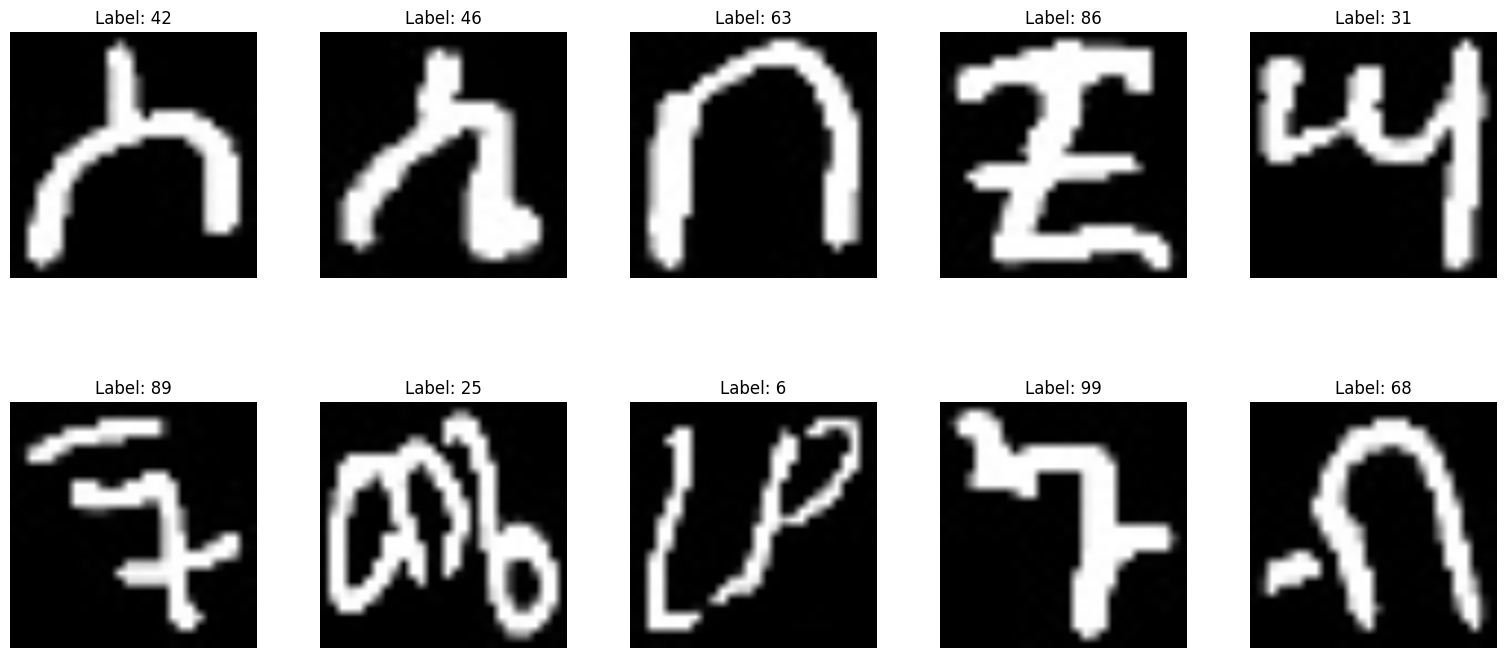

In [3]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1))
])

dataset = Ethiopic(data_dir ="/content/drive/My Drive/neuro140fp/am_dataset",csv_path = "/content/drive/My Drive/neuro140fp/supported_chars.csv", transform = train_transform)
indices = random.sample(range(len(dataset)), 10)

# Set up the plot
fig, axs = plt.subplots(2, 5, figsize=(20, 8))
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

for i, idx in enumerate(indices):
    image, label = dataset[idx]

    image_np = image.numpy().transpose((1, 2, 0))
    if image_np.shape[2] == 1:
        image_np = np.squeeze(image_np, axis=2)
    axs[i].imshow(image_np, cmap='gray')
    axs[i].set_title(f'Label: {label}')
    axs[i].axis('off')

plt.show()

##Do train and test split

In [4]:
from torch.utils.data import DataLoader, random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

##Train with alexnet

In [ ]:
torch.cuda.empty_cache()
from matplotlib.font_manager import FontProperties
import seaborn as sns
from sklearn.metrics import confusion_matrix


tsifet = FontProperties()
tsifet.set_file("/content/drive/My Drive/neuro140fp/NotoSerif.ttf")

import torch
import pandas as pd
from torchvision import models
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from fastprogress import progress_bar


model_dict = {
    # 'AlexNet': models.alexnet(),
    # 'ResNet': models.resnet18(),
    # 'DenseNet': models.densenet121(),
    'VGG_net': models.vgg16_bn(),
}

results = {
    'model_name': [],
    'epoch': [],
    'train_accuracy': [],
    'val_accuracy': [],
    'train_loss': [],
    'val_loss': [],
}
mistakes = []
actuals = []
predictions = []
df = pd.read_csv("/content/drive/My Drive/neuro140fp/supported_chars.csv")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

for model_name, model in model_dict.items():
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(20):
        model.train()
        train_correct = 0
        train_total = 0
        train_loss_accum = 0

        for inputs, labels in progress_bar(train_dataloader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_accum += loss.item() * inputs.size(0)  # Aggregate the loss
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_accuracy = train_correct / train_total
        train_loss = train_loss_accum / train_total

        model.eval()
        val_correct = 0
        val_total = 0
        val_loss_accum = 0
        with torch.no_grad():
            for inputs, labels in val_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss_accum += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs.data, 1)

                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                incorrect_indices = (predicted != labels).nonzero().squeeze()
                incorrect_samples = inputs[incorrect_indices]
                incorrect_labels = labels[incorrect_indices]
                incorrect_preds = predicted[incorrect_indices]
                if epoch == 19:
                  for idx in range(len(incorrect_indices)):
                    predictions.extend(predicted.cpu().numpy())
                    actuals.extend(labels.cpu().numpy())
                    actual_char = df["Character"][incorrect_labels[idx].item()]
                    predicted_char = df["Character"][incorrect_preds[idx].item()]
                    mistake_info = {
                        "image_index": incorrect_indices[idx].item(),
                        "actual_character": actual_char,
                        "predicted_character": predicted_char
                    }
                    mistakes.append(mistake_info)
                    cm = confusion_matrix(actuals, predictions)

                    image = transforms.ToPILImage()(incorrect_samples[idx])
                    plt.imshow(image)
                    plt.title(f"Mistaken: Actual -> {actual_char}, Predicted -> {predicted_char}", fontproperties=tsifet)
                    plt.savefig(f"/content/drive/My Drive/neuro140fp/Mistake{model_name}_{actual_char}_vs_{predicted_char}.png")



        val_accuracy = val_correct / val_total
        val_loss = val_loss_accum / val_total


        print(f'Epoch {epoch} - Model: {model_name} Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

        # Save results
        results['model_name'].append(model_name)
        results['epoch'].append(epoch)
        results['train_accuracy'].append(train_accuracy)
        results['val_accuracy'].append(val_accuracy)
        results['train_loss'].append(train_loss)
        results['val_loss'].append(val_loss)
        models_folder = "models_path"

        if not os.path.exists(models_folder):
          os.makedirs(models_folder)

        torch.save(model.state_dict(), os.path.join(models_folder, f'{model_name}_epoch_{epoch}.pth'))

# Convert results to DataFrame and save to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv(f'{model_name}_training_results{epoch}.csv', index=False)





cuda


Epoch 0 - Model: VGG_net Train Acc: 0.0553, Val Acc: 0.1803, Train Loss: 4.8505, Val Loss: 3.2048


In [14]:
print(mistakes)

[{'image_index': 18, 'actual_character': 'ፕ', 'predicted_character': 'ኘ'}, {'image_index': 24, 'actual_character': 'ኞ', 'predicted_character': 'ኛ'}, {'image_index': 26, 'actual_character': 'ሉ', 'predicted_character': 'ለ'}, {'image_index': 1, 'actual_character': 'ኀ', 'predicted_character': 'ኅ'}, {'image_index': 7, 'actual_character': 'ፕ', 'predicted_character': 'ኘ'}, {'image_index': 19, 'actual_character': 'ሶ', 'predicted_character': 'ሰ'}, {'image_index': 26, 'actual_character': 'ሀ', 'predicted_character': 'ህ'}, {'image_index': 28, 'actual_character': 'ቲ', 'predicted_character': 'ተ'}, {'image_index': 2, 'actual_character': 'ች', 'predicted_character': 'ኝ'}, {'image_index': 5, 'actual_character': 'ሸ', 'predicted_character': 'ሽ'}, {'image_index': 25, 'actual_character': 'ፓ', 'predicted_character': 'ፖ'}, {'image_index': 5, 'actual_character': 'ፕ', 'predicted_character': 'ኘ'}, {'image_index': 13, 'actual_character': 'ሶ', 'predicted_character': 'ሰ'}, {'image_index': 16, 'actual_character': 'ፕ

In [15]:
mistakes_df = pd.DataFrame(mistakes)

In [16]:
mistakes_df.to_csv('mistakes.csv', index=False, encoding='utf-8-sig')


/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4715 (\N{ETHIOPIC SYLLABLE VAA}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4765 (\N{ETHIOPIC SYLLABLE NYE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4638 (\N{ETHIOPIC SYLLABLE MO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4950 (\N{ETHIOPIC SYLLABLE PO}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4725 (\N{ETHIOPIC SYLLABLE TE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/seaborn/utils.py:61: UserWarning: Glyph 4716 (\N{ETHIOPIC SYLLABLE VEE}) missing from current font.
  fig.canvas.draw()
/usr/local/lib/python3.10/dist-packages/sea

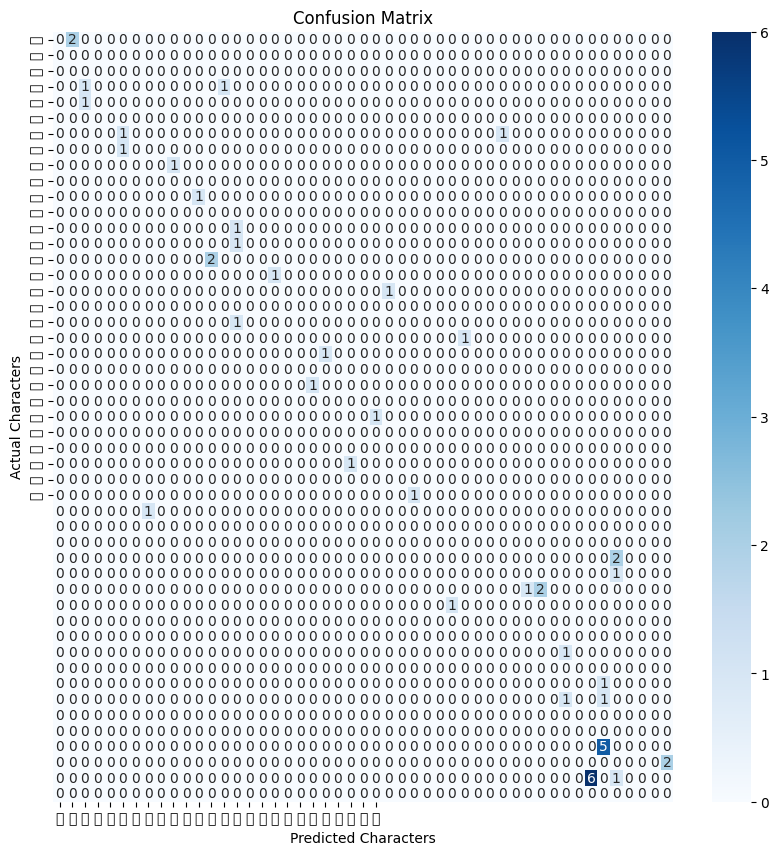